In [52]:
# Imports
import sys
import os
import re
import tqdm
import time
import sklearn
import numpy as np
import pandas as pd
import scipy
import copy
import random
import math
import json
import torch
import torch.nn as nn
from torch.autograd import grad
import torch.nn.functional as F
from load_dataset import load, generate_random_dataset
from classifier import *
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from scipy import stats
from scipy.stats import rankdata
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from IPython.display import Markdown, display
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

In [3]:
c = 0.003
epoch_num = 1000
th = 0.0
dataset = 'syn'
val_seeds = [42, 99, 67, 2, 23]
val_seed = val_seeds[0]
classifier_name = 'SVM'

In [4]:
def generate_orig_data_point(N):
    S = np.random.binomial(1, 0.5, N).reshape(-1, 1)
    X1 = np.where((S + 0.6*np.random.uniform(0, 1, N).reshape(-1, 1))>0.5, 1, 0)
    X3 = np.around(2*np.random.uniform(0, 1, N).reshape(-1, 1))

    alpha = 1
    beta = 0.2
    X2 = np.where((alpha * X1 + beta * X3 + 0.1*np.random.uniform(0, 1, N).reshape(-1, 1))>0.5, 1, 0)
#     print(np.corrcoef(X2.ravel(), S.ravel()))
    
    Y = np.where((0.3*X3 + 0.2*np.random.uniform(-1, 1, N).reshape(-1, 1))>0.3, 1, 0)

    X4 = np.where((0.7*Y + 0.3*np.random.uniform(-1, 1, N).reshape(-1, 1))>0.5, 1, 0)

    return np.concatenate([S, X1, X2, X3, X4, Y], axis=1)

In [5]:
np.random.seed(0)
Number_of_training_samples = 10**5
Number_of_test_samples = 2*10**4
data = generate_orig_data_point(Number_of_training_samples+Number_of_test_samples)
data_train = data[:Number_of_training_samples]
data_test = data[Number_of_training_samples:]

X_train = data_train[:, :5]
y_train = data_train[:, 5]
X_test = data_test[:, :5]
y_test = data_test[:, 5]

X_train_orig = pd.DataFrame({'S':X_train[:, 0], 'X1':X_train[:, 1], 'X2':X_train[:, 2],
                             'X3':X_train[:, 3], 'X4':X_train[:, 4]})
X_test_orig = pd.DataFrame({'S':X_test[:, 0], 'X1':X_test[:, 1], 'X2':X_test[:, 2],
                            'X3':X_test[:, 3], 'X4':X_test[:, 4]})

sc = StandardScaler()
X_train = sc.fit_transform(X_train_orig)
X_test = sc.transform(X_test_orig)

In [6]:
def train_clf(model, info_dict):
    val_iter = 10
    epoch = model.epoch_num
    model.epoch_num = val_iter
    val_num = epoch // val_iter
    min_loss = 2048
    best_model = None
    for _ in range(val_num):
        model.fit_info(info_dict)
        loss = model.compute_loss(info_dict)
        if loss < min_loss:
            torch.save(model.state_dict(), 'best_params/best-test.pth')
            min_loss = loss
    model.load_state_dict(torch.load('best_params/best-test.pth'))
    model.adjust_threshold(info_dict)
    model.eval()
    return model

In [7]:
def get_A_idx(x, y, A=None, A_val=None):
    if A is None:
        return x.index
    elif A == 'y':
        return np.arange(len(y))[y==A_val]
    elif A in x.columns:
        return x[x[A]==A_val].index
    else:
        raise NotImplementedError

In [8]:
info_dict = dict()
info_dict['x_train'] = X_train
info_dict['y_train'] = y_train
info_dict['x_val'] = X_train
info_dict['y_val'] = y_train

In [9]:
clf = eval(classifier_name)(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c)

clf = train_clf(clf, info_dict=info_dict)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

f1_0 = computeF1(y_test, y_pred_test)
print("Initial F1: ", f1_0)

Best Threshold=0.924106, G-mean=0.957
Initial statistical parity:  -0.0016128242466197373
Initial TPR parity:  0.0020104626123428337
Initial predictive parity:  -0.00012119289579159975
Initial loss:  0.12853822280314087
Initial accuracy:  0.95895
Initial F1:  0.957044943232355


## Random

In [49]:
# Sample Rate: 60%
X_train_orig_sampled, _, y_train_sampled, _ = \
    train_test_split(X_train_orig, y_train, test_size=0.4, random_state=1)

In [50]:
sc = StandardScaler()
X_train_sampled = sc.fit_transform(X_train_orig_sampled)
X_test = sc.transform(X_test_orig)

info_dict = dict()
info_dict['x_train'] = X_train_sampled
info_dict['y_train'] = y_train_sampled
info_dict['x_val'] = X_train_sampled
info_dict['y_val'] = y_train_sampled

In [51]:
clf = eval(classifier_name)(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c)

clf = train_clf(clf, info_dict=info_dict)

y_pred_test = clf.predict_proba(X_test)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

f1_0 = computeF1(y_test, y_pred_test)
print("Initial F1: ", f1_0)

Best Threshold=0.922252, G-mean=0.956
Initial statistical parity:  -0.002037616094423489
Initial TPR parity:  0.001752620426052398
Initial predictive parity:  0.0004552745460614238
Initial loss:  0.12828199884133115
Initial accuracy:  0.95895
Initial F1:  0.957044943232355


## S & X4

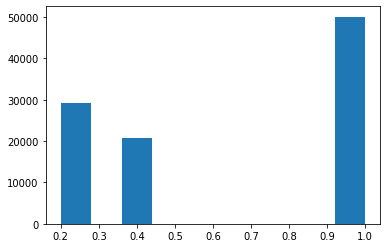

In [14]:
p = np.ones_like(X_train_orig.S).astype(float)
p[(X_train_orig.S==0)&(X_train_orig.X4==0)] = 0.2
p[(X_train_orig.S==1)&(X_train_orig.X4==1)] = 0.4
plt.hist(p)
plt.show()

In [15]:
np.random.seed(1)
sample_bool = np.zeros(len(X_train))
for idx in range(len(X_train)):
    sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [16]:
X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
X_train_sampled = X_train[np.where(sample_bool)[0]]
y_train_sampled = y_train[np.where(sample_bool)[0]]

In [18]:
sc = StandardScaler()
X_train_sampled = sc.fit_transform(X_train_orig_sampled)
X_test = sc.transform(X_test_orig)

info_dict = dict()
info_dict['x_train'] = X_train_sampled
info_dict['y_train'] = y_train_sampled
info_dict['x_val'] = X_train_sampled
info_dict['y_val'] = y_train_sampled

In [19]:
clf = eval(classifier_name)(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c)

clf = train_clf(clf, info_dict=info_dict)

y_pred_test = clf.predict_proba(X_test)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

f1_0 = computeF1(y_test, y_pred_test)
print("Initial F1: ", f1_0)

Best Threshold=0.917979, G-mean=0.962
Initial statistical parity:  0.008063014103741495
Initial TPR parity:  0.007505934744423182
Initial predictive parity:  -0.013591943797080397
Initial loss:  0.12773166066875494
Initial accuracy:  0.95895
Initial F1:  0.957044943232355


## X2 & X4

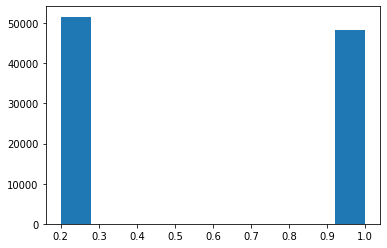

In [22]:
p = np.ones_like(X_train_orig.S).astype(float)
p[(X_train_orig.X2==1)&(X_train_orig.X4==0)] = 0.2
p[(X_train_orig.X2==0)&(X_train_orig.X4==1)] = 0.2
plt.hist(p)
plt.show()

In [23]:
np.random.seed(1)
sample_bool = np.zeros(len(X_train))
for idx in range(len(X_train)):
    sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [24]:
X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
X_train_sampled = X_train[np.where(sample_bool)[0]]
y_train_sampled = y_train[np.where(sample_bool)[0]]

In [25]:
sum(y_train_sampled)/len(y_train_sampled)

0.5450440472336292

In [26]:
sc = StandardScaler()
X_train_sampled = sc.fit_transform(X_train_orig_sampled)
X_test = sc.transform(X_test_orig)

info_dict = dict()
info_dict['x_train'] = X_train_sampled
info_dict['y_train'] = y_train_sampled
info_dict['x_val'] = X_train_sampled
info_dict['y_val'] = y_train_sampled

In [27]:
clf = eval(classifier_name)(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c)

clf = train_clf(clf, info_dict=info_dict)

y_pred_test = clf.predict_proba(X_test)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

f1_0 = computeF1(y_test, y_pred_test)
print("Initial F1: ", f1_0)

Best Threshold=0.912145, G-mean=0.963
Initial statistical parity:  -0.011854606246039956
Initial TPR parity:  -0.0038461630324343465
Initial predictive parity:  0.013980392009995679
Initial loss:  0.12688622879516342
Initial accuracy:  0.95895
Initial F1:  0.957044943232355


## X2 & Y

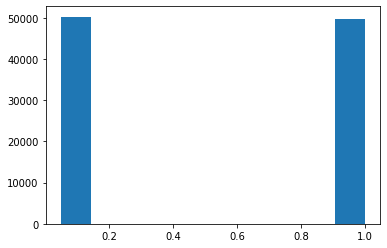

In [28]:
p = np.ones_like(X_train_orig.S).astype(float)
p[(X_train_orig.X2==1)&(y_train==0)] = 0.1
p[(X_train_orig.X2==0)&(y_train==1)] = 0.05
plt.hist(p)
plt.show()

In [29]:
np.random.seed(1)
sample_bool = np.zeros(len(X_train))
for idx in range(len(X_train)):
    sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [30]:
X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
X_train_sampled = X_train[np.where(sample_bool)[0]]
y_train_sampled = y_train[np.where(sample_bool)[0]]

In [31]:
sum(y_train_sampled)/len(y_train_sampled)

0.5577609277430865

In [32]:
sc = StandardScaler()
X_train_sampled = sc.fit_transform(X_train_orig_sampled)
X_test = sc.transform(X_test_orig)

info_dict = dict()
info_dict['x_train'] = X_train_sampled
info_dict['y_train'] = y_train_sampled
info_dict['x_val'] = X_train_sampled
info_dict['y_val'] = y_train_sampled

In [33]:
clf = eval(classifier_name)(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c)

clf = train_clf(clf, info_dict=info_dict)

y_pred_test = clf.predict_proba(X_test)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

f1_0 = computeF1(y_test, y_pred_test)
print("Initial F1: ", f1_0)

Best Threshold=0.370362, G-mean=0.973
Initial statistical parity:  -0.2393811200548253
Initial TPR parity:  -0.18039672951707286
Initial predictive parity:  0.2006994958007311
Initial loss:  0.28007637152914583
Initial accuracy:  0.82025
Initial F1:  0.8382888758940219


In [34]:
parent_1 = 'X2'
parent_2 = 'y'
parent_3 = 'y'
sens_attr = 'S'
A = 'y'
A_val = 1

In [35]:
info_dict = dict()
info_dict['th'] = 0.0
info_dict['balance'] = 3
info_dict['x_train'] = X_train_sampled
info_dict['y_train'] = y_train_sampled
info_dict['x_val'] = X_train_sampled
info_dict['y_val'] = y_train_sampled

protected_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_3).unique()):
            idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_1)==v) &\
                                       (get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_2)==u) &\
                                       (get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_3)==w) &\
                                       (get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), sens_attr)==0)].index
            idx = idx.intersection(get_A_idx(X_train_orig_sampled, pd.Series(y_train_sampled), A, A_val))
            if len(idx)>0:
                protected_groups.append(idx)

privileged_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_3).unique()):
            idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_1)==v) &\
                                       (get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_2)==u) &\
                                       (get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_3)==w) &\
                                       (get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), sens_attr)==1)].index
            idx = idx.intersection(get_A_idx(X_train_orig_sampled, pd.Series(y_train_sampled), A, A_val))
            if len(idx)>0:
                privileged_groups.append(idx)

info_dict['train_regularizer'] = [protected_groups, privileged_groups]

protected_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_3).unique()):
            idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_1)==v) &\
                                       (get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_2)==u) &\
                                       (get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_3)==w) &\
                                       (get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), sens_attr)==0)].index
            idx = idx.intersection(get_A_idx(X_train_orig_sampled, pd.Series(y_train_sampled), A, A_val))
            if len(idx)>0:
                protected_groups.append(idx)

privileged_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_3).unique()):
            idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_1)==v) &\
                                       (get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_2)==u) &\
                                       (get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), parent_3)==w) &\
                                       (get_attr(X_train_orig_sampled, pd.Series(y_train_sampled), sens_attr)==1)].index
            idx = idx.intersection(get_A_idx(X_train_orig_sampled, pd.Series(y_train_sampled), A, A_val))
            if len(idx)>0:
                privileged_groups.append(idx)

info_dict['val_regularizer'] = [protected_groups, privileged_groups]

In [36]:
clf = eval(classifier_name+'_Reg_Bound')(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c)

clf = train_clf(clf, info_dict)

y_pred_test = clf.predict_proba(X_test)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

f1_0 = computeF1(y_test, y_pred_test)
print("Initial F1: ", f1_0)

Best Threshold=0.915941, G-mean=0.957
Initial statistical parity:  0.003195144344904477
Initial TPR parity:  0.004656816307746392
Initial predictive parity:  -0.0068471390423753276
Initial loss:  0.12691709942046636
Initial accuracy:  0.95895
Initial F1:  0.957044943232355


## Y

In [134]:
classifier_name = 'SVM'

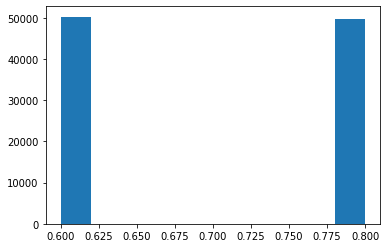

In [42]:
p = np.ones_like(X_train_orig.S).astype(float)
p[y_train==0] = 0.6
p[y_train==1] = 0.8
plt.hist(p)
plt.show()

In [43]:
np.random.seed(1)
sample_bool = np.zeros(len(X_train))
for idx in range(len(X_train)):
    sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [44]:
X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
X_train_sampled = X_train[np.where(sample_bool)[0]]
y_train_sampled = y_train[np.where(sample_bool)[0]]

In [45]:
sum(y_train_sampled)/len(y_train_sampled)

0.5688723738745176

In [47]:
sc = StandardScaler()
X_train_sampled = sc.fit_transform(X_train_orig_sampled)
X_test = sc.transform(X_test_orig)

info_dict = dict()
info_dict['x_train'] = X_train_sampled
info_dict['y_train'] = y_train_sampled
info_dict['x_val'] = X_train_sampled
info_dict['y_val'] = y_train_sampled

In [48]:
clf = eval(classifier_name)(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c)

clf = train_clf(clf, info_dict=info_dict)

y_pred_test = clf.predict_proba(X_test)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

f1_0 = computeF1(y_test, y_pred_test)
print("Initial F1: ", f1_0)

Best Threshold=0.935776, G-mean=0.957
Initial statistical parity:  -0.0011546064740363682
Initial TPR parity:  0.002221612320333799
Initial predictive parity:  -0.0008499329853262072
Initial loss:  0.12469993133393052
Initial accuracy:  0.95895
Initial F1:  0.957044943232355
